In [272]:
# Ames house prices predition
# competition link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [273]:
# reading data

train = pd.read_csv('data/train.csv')
train.set_index('Id',  inplace=True)

test = pd.read_csv('data/test.csv')
test.set_index('Id',  inplace=True)

In [274]:
# combining train and test

ntrain = train.shape[0]
ntest = test.shape[0]
prices = train.SalePrice.values
data = pd.concat((train, test), sort=False).reset_index(drop=True)
data.drop(['SalePrice'], axis=1, inplace=True)

In [210]:
data = data.fillna("None")

In [275]:
# setting categoric NA to None or mode 

data["PoolQC"] = data["PoolQC"].fillna("None")
data["MiscFeature"] = data["MiscFeature"].fillna("None")
data["Alley"] = data["Alley"].fillna("None")
data["Fence"] = data["Fence"].fillna("None")
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data['MSSubClass'] = data['MSSubClass'].fillna("None")
data["Functional"] = data["Functional"].fillna("Typ")
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].mode()[0])
data['MSSubClass'] = data['MSSubClass'].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data[col] = data[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data[col] = data[col].fillna('None')
data["MSZoning"] = data.groupby("Neighborhood")["MSZoning"].transform(
    lambda x: x.fillna(x.mode()[0]))

# setting numeric NA to 0, mode or median

for col in ('GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
data["GarageYrBlt"] = data.groupby("Neighborhood")["GarageYrBlt"].transform(
    lambda x: x.fillna(x.mode()[0]))
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

# dropping feature with only 3 entries different from mode

data = data.drop(['Utilities'], axis=1)

# dropping outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# dealing with inconsistencies
s = (data['PoolArea']>0) & (data['PoolQC'] == 'None')
for i in (enumerate(s)):
    data.at[i, 'PoolQC'] = 'Fa'
    
# transforming numeric that are actually categoric to categoric

data['MSSubClass'] = data['MSSubClass'].apply(str)

data['OverallCond'] = data['OverallCond'].astype(str)

data['YrSold'] = data['YrSold'].astype(str)

data['MoSold'] = data['MoSold'].astype(str)

In [276]:
# assigning cleaned data back to train and test

pd.options.mode.chained_assignment = None  # default='warn'

train = data[:ntrain]
test = data[ntrain:]

In [277]:
# encoding categoric features to apply algorithm

dummiestrain = pd.get_dummies(train)
print(train.shape)
print(dummiestrain.shape)
print(prices.shape)

(1460, 78)
(1460, 334)
(1460,)


In [ ]:
# RFE

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = dummiestrain
Y = prices

model = LogisticRegression(solver="saga", multi_class="auto")
rfe = RFE(model, 50)
fit = rfe.fit(X, Y)

print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

In [ ]:
# PCA

from sklearn.decomposition import PCA

X = dummiestrain
Y = prices

pca = PCA(n_components=50, svd_solver="auto")
fit = pca.fit(X)

train_pca = pca.transform(dummiestrain)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

X = dummiestrain
Y = prices

model = ExtraTreesClassifier(n_estimators=100)
model.fit(X, Y)
print(model.feature_importances_)

In [281]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train,X_test,y_train,y_test = train_test_split(dummiestrain, prices, test_size = 0.4,random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(876, 334) (584, 334) (876,) (584,)


In [282]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

regressor=SVR(kernel='linear')

regressor.fit(X_train,y_train)
train_pre = regressor.predict(X_train)
test_pre = regressor.predict(X_test)

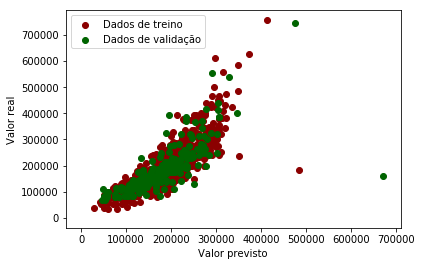

In [266]:
plt.scatter(train_pre, y_train, c = "darkred",  label = "Dados de treino")
plt.scatter(test_pre,y_test, c = "darkgreen",  label = "Dados de validação")
plt.xlabel("Valor previsto")
plt.ylabel("Valor real")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

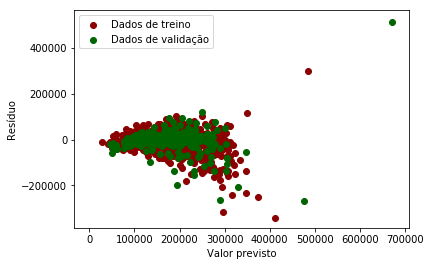

In [267]:
plt.scatter(train_pre, train_pre - y_train, c = "darkred",  label = "Dados de treino")
plt.scatter(test_pre, test_pre - y_test, c = "darkgreen",  label = "Dados de validação")
plt.xlabel("Valor previsto")
plt.ylabel("Resíduo")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

In [283]:
print("train score {:.4f}".format(regressor.score(X_train,y_train)))
print("test score {:.4f}".format(regressor.score(X_test, y_test)))

train score 0.7721
test score 0.6675


In [217]:
i = np.where(abs(test_pre-y_test) > 100000)

test_pre = np.delete(test_pre, i)
y_test = np.delete(y_test, i)


In [218]:
j = np.where(abs(train_pre-y_train) > 100000)

train_pre = np.delete(train_pre, j)
y_train = np.delete(y_train, j)

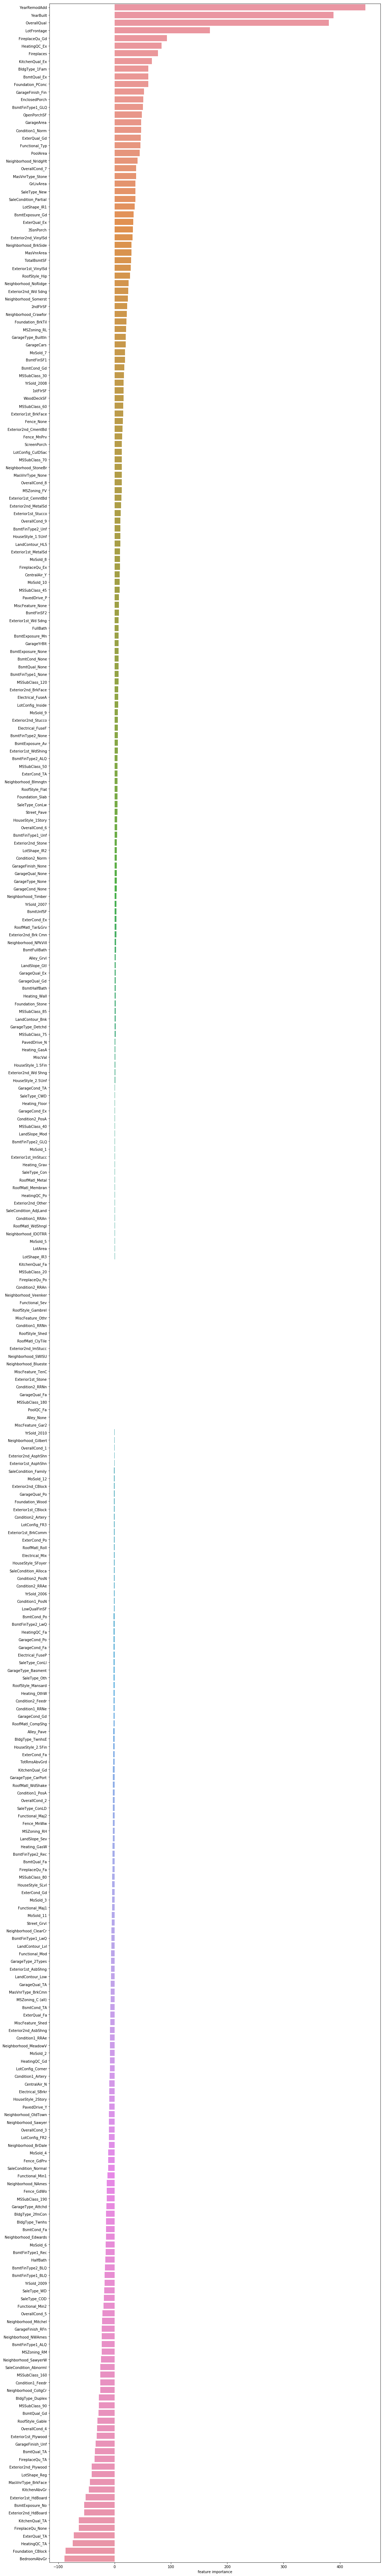

In [257]:
ranking = np.argsort(-regressor.coef_.ravel())
f, ax = plt.subplots(figsize=(15, 100))
sn.barplot(x=regressor.coef_.ravel()[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

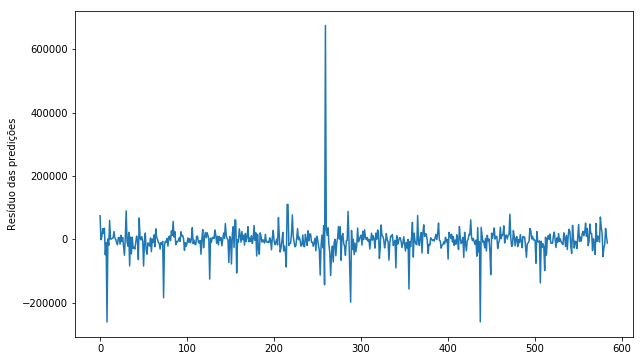

In [318]:
waste = test_pre-y_test
plt.figure(figsize=(10, 6))
plt.plot(waste)
plt.ylabel('Resíduo das predições')
plt.show()

In [323]:
print("Resíduo médio: {:.4f}".format(np.mean(abs(waste))))

Resíduo médio: 23148.6148
